## Question 16

Are comments or submissions more toxic?

#### Operationalized questions: 
* Compare the percentage of comments identified as hateful or offensive to the percentage of submissions selftext classified as hateful or offensive

* Compare Detoxify scores for hateful or offensive comments and submission selftest

#### Hypothesis:
* Classification: Comments will have more items identified as hateful or offensive than will the text of submissions

* Detoxify: Comments will have higher scores on Detoxify measures than will the text of submissions

#### Results:
By isolating the toxic language (hate or offensive) in both the submissions and comments datasets, we were able to find the proportions of toxic language in each. We were surprised that while around 55% of comments were classified as toxic, only around 11% of submissions were. It should be noted, however, that of the 187,874 submissions, only 26,444 were classified, so only those were included in the analysis. Comparing toxic submissions and comments using Welch’s T-test revealed that, for each of the Detoxify metrics except Identity Attack, the p-value was lower than the 5% significance level, leading us to reject the Null Hypothesis that there is no difference between the means. For Identity Attack, the p-value was higher than the 5% significance level, leading us to fail to reject the Null Hypothesis.

We then break down the two conditions further, to compare the means between hate submissions and comments, as well as offensive submissions and comments. In the former, we find the one metric where we fail to reject the Null Hypothesis is Threat, whereas in the latter, the one metric where we fail to reject the Null Hypothesis is Identity Attack.


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#### Read in the Comments and Submissions data

In [ ]:
c = pd.read_csv('../data/processed/comments.csv')
s = pd.read_csv('../data/processed/submissions.csv')

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3228: DtypeWarning: Columns (5,6,7,8,9,11,12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Create separate datasets for submissions and comments Hate, Offensive and total toxic posts, and find and visualize the proportions in each dataset.

As noted in the results, a majority of the submissions posts are classified as Null values, and have been dropped from this analysis. 

In [ ]:
submissions_hate = s[s.selftext_label == 0]
submissions_offensive = s[s.selftext_label == 1]
submissions_toxic = s[(s.selftext_label == 0) | (s.selftext_label == 1)]

comments_hate = c[c.davidson_label == 0]
comments_offensive = c[c.davidson_label == 1]
comments_toxic = c[c.davidson_label != 2]


In [ ]:
proportion_df = pd.concat([pd.Series(len(submissions_hate)/len(s.dropna(subset=['selftext_label']))).to_frame(name='Submissions - Hate'),
                    pd.Series(len(submissions_offensive)/len(s.dropna(subset=['selftext_label']))).to_frame(name='Submissions - Offensive'),
                    pd.Series(len(submissions_toxic)/len(s.dropna(subset=['selftext_label']))).to_frame(name='Submissions - Toxic'),          
                    pd.Series(len(comments_hate)/len(c)).to_frame(name='Comments - Hate'),
                    pd.Series(len(comments_offensive)/len(c)).to_frame(name='Comments - Offensive'),
                    pd.Series(len(comments_toxic)/len(c)).to_frame(name='Comments - Toxic'),     
                   ],axis=1).rename(index={0:'proportion'})
proportion_df

,Submissions - Hate,Submissions - Offensive,Submissions - Toxic,Comments - Hate,Comments - Offensive,Comments - Toxic
proportion,0.018582,0.088428,0.107009,0.205425,0.345789,0.551213


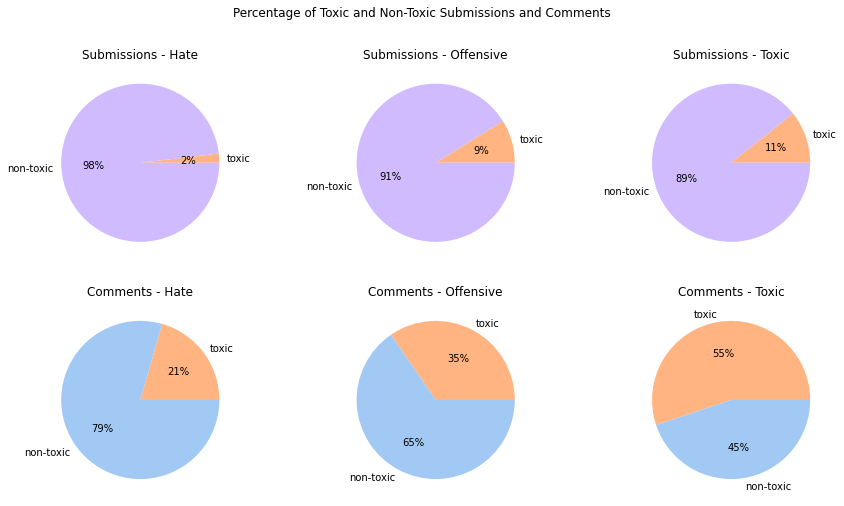

In [ ]:
sub_hate = float(proportion_df['Submissions - Hate'])
sub_off = float(proportion_df['Submissions - Offensive'])
sub_total = float(proportion_df['Submissions - Toxic'])

com_hate = float(proportion_df['Comments - Hate'])
com_off = float(proportion_df['Comments - Offensive'])
com_total = float(proportion_df['Comments - Toxic'])

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
colors = sns.color_palette('pastel')

axes[0,0].pie([sub_hate, 1-sub_hate], labels=['toxic','non-toxic'], colors=[colors[1],colors[4]], autopct='%.0f%%')
axes[0,0].set_title('Submissions - Hate')
axes[0,1].pie([sub_off, 1-sub_off], labels=['toxic','non-toxic'], colors=[colors[1],colors[4]], autopct='%.0f%%')
axes[0,1].set_title('Submissions - Offensive')
axes[0,2].pie([sub_total, 1-sub_total], labels=['toxic','non-toxic'], colors=[colors[1],colors[4]], autopct='%.0f%%')
axes[0,2].set_title('Submissions - Toxic')

axes[1,0].pie([com_hate, 1-com_hate], labels=['toxic','non-toxic'], colors=[colors[1],colors[0]], autopct='%.0f%%')
axes[1,0].set_title('Comments - Hate')
axes[1,1].pie([com_off, 1-com_off], labels=['toxic','non-toxic'], colors=[colors[1],colors[0]], autopct='%.0f%%')
axes[1,1].set_title('Comments - Offensive')
axes[1,2].pie([com_total, 1-com_total], labels=['toxic','non-toxic'], colors=[colors[1],colors[0]], autopct='%.0f%%')
axes[1,2].set_title('Comments - Toxic')

plt.suptitle('Percentage of Toxic and Non-Toxic Submissions and Comments')
plt.show()


#### Extract the Detoxify scores from each dataset and gather test statistics

In [ ]:
detoxify = ['toxicity', 'severe_toxicity', 'obscene','identity_attack', 'insult', 'threat', 'sexual_explicit']

submissions_hate = submissions_hate[detoxify]
submissions_offensive = submissions_offensive[detoxify]
submissions_toxic = submissions_toxic[detoxify]

comments_hate = comments_hate[detoxify]
comments_offensive = comments_offensive[detoxify]
comments_toxic = comments_toxic[detoxify]


In [ ]:
def collect_toxicity_test_statistics(dataset_1, dataset_2, alpha=0.05): 
    ttest_df = pd.DataFrame(columns=['variable','t-statistic','p-value','H0','variance'])
    
    variables = ['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult','threat', 'sexual_explicit']
    ttest_df['variable'] = variables

    for variable in variables:
        ttest_x=dataset_1[variable]
        ttest_y=dataset_2[variable]
        
        if np.var(ttest_x) != np.var(ttest_y):
            ttest_df.loc[ttest_df['variable']==variable,'variance'] = 'unequal'
            ttest = ttest_ind(ttest_x, ttest_y, nan_policy='omit', equal_var=False)
            ttest_df.loc[ttest_df['variable']==variable,'t-statistic'] = ttest[0]
            ttest_df.loc[ttest_df['variable']==variable,'p-value'] = ttest[1]
            if ttest[1] > alpha:
                ttest_df.loc[ttest_df['variable']==variable,'H0'] = 'fail to reject'
            else:
                ttest_df.loc[ttest_df['variable']==variable,'H0'] = 'reject'
        else:
            ttest_df.loc[ttest_df['variable']==variable,'variance'] = 'equal'
            ttest = ttest_ind(ttest_x, ttest_y, nan_policy='omit')
            ttest_df.loc[ttest_df['variable']==variable,'t-statistic'] = ttest[0]
            ttest_df.loc[ttest_df['variable']==variable,'p-value'] = ttest[1]
            if ttest[1] > alpha:
                ttest_df.loc[ttest_df['variable']==variable,'H0'] = 'fail to reject'
            else:
                ttest_df.loc[ttest_df['variable']==variable,'H0'] = 'reject'
    
    return ttest_df


In [ ]:
collect_toxicity_test_statistics(submissions_toxic, comments_toxic)

,variable,t-statistic,p-value,H0,variance
0,toxicity,-22.589415,0.0,reject,unequal
1,severe_toxicity,-33.942919,0.0,reject,unequal
2,obscene,-24.015849,0.0,reject,unequal
3,identity_attack,1.072825,0.283446,fail to reject,unequal
4,insult,-41.008661,0.0,reject,unequal
5,threat,-8.547225,0.0,reject,unequal
6,sexual_explicit,-17.90997,0.0,reject,unequal


#### Visualize the mean Detoxify scores for comments and submissions 

Text(0.5, 1.02, 'Detoxify Scores for Toxic Submissions and Comments')

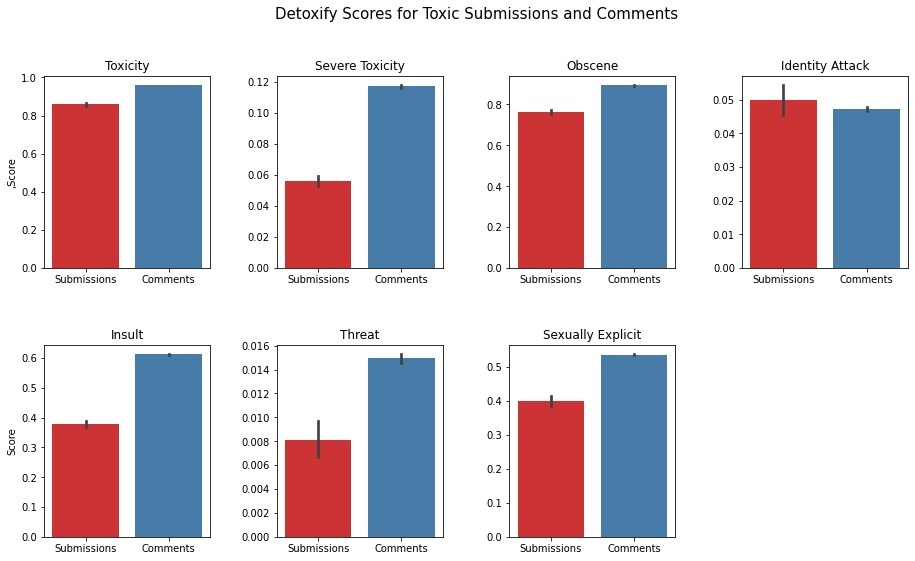

In [ ]:
toxic_toxicity_df = pd.concat([submissions_toxic.toxicity.to_frame(name='Submissions - Toxic'),
                  comments_toxic.toxicity.to_frame(name='Comments - Toxic')],axis=1)
toxic_severe_toxicity_df = pd.concat([submissions_toxic.severe_toxicity.to_frame(name='Submissions - Toxic'),
                  comments_toxic.severe_toxicity.to_frame(name='Comments - Toxic')],axis=1)
toxic_obscene_df = pd.concat([submissions_toxic.obscene.to_frame(name='Submissions - Toxic'),
                  comments_toxic.obscene.to_frame(name='Comments - Toxic')],axis=1)
toxic_identity_attack_df = pd.concat([submissions_toxic.identity_attack.to_frame(name='Submissions - Toxic'),
                  comments_toxic.identity_attack.to_frame(name='Comments - Toxic')],axis=1)
toxic_insult_df = pd.concat([submissions_toxic.insult.to_frame(name='Submissions - Toxic'),
                  comments_toxic.insult.to_frame(name='Comments - Toxic')],axis=1)
toxic_threat_df = pd.concat([submissions_toxic.threat.to_frame(name='Submissions - Toxic'),
                  comments_toxic.threat.to_frame(name='Comments - Toxic')],axis=1)
toxic_sexual_explicit_df = pd.concat([submissions_toxic.sexual_explicit.to_frame(name='Submissions - Toxic'),
                  comments_toxic.sexual_explicit.to_frame(name='Comments - Toxic')],axis=1)

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

sns.barplot(ax=axes[0, 0], data=toxic_toxicity_df, palette='Set1').set(xticklabels=['Submissions','Comments'],ylabel=',Score',title='Toxicity')
sns.barplot(ax=axes[0, 1], data=toxic_severe_toxicity_df, palette='Set1').set(xticklabels=['Submissions','Comments'],ylabel='',title='Severe Toxicity')
sns.barplot(ax=axes[0, 2], data=toxic_obscene_df, palette='Set1').set(xticklabels=['Submissions','Comments'],ylabel='',title='Obscene')
sns.barplot(ax=axes[0, 3], data=toxic_identity_attack_df, palette='Set1').set(xticklabels=['Submissions','Comments'],ylabel='',title='Identity Attack')
sns.barplot(ax=axes[1, 0], data=toxic_insult_df, palette='Set1').set(xticklabels=['Submissions','Comments'],ylabel='Score',title='Insult')
sns.barplot(ax=axes[1, 1], data=toxic_threat_df, palette='Set1').set(xticklabels=['Submissions','Comments'],ylabel='',title='Threat')
sns.barplot(ax=axes[1, 2], data=toxic_sexual_explicit_df, palette='Set1').set(xticklabels=['Submissions','Comments'],ylabel='',title='Sexually Explicit')
axes[1, 3].set_visible(False)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.suptitle('Detoxify Scores for Toxic Submissions and Comments', y=(1.02),size=15)

    

#### Gather test statistics for both Hate and Offensive submissions and comments

In [ ]:
collect_toxicity_test_statistics(submissions_hate, comments_hate)

,variable,t-statistic,p-value,H0,variance
0,toxicity,-13.622078,0.0,reject,unequal
1,severe_toxicity,-11.353685,0.0,reject,unequal
2,obscene,-16.4891,0.0,reject,unequal
3,identity_attack,5.458085,0.0,reject,unequal
4,insult,-16.770148,0.0,reject,unequal
5,threat,0.937779,0.34885,fail to reject,unequal
6,sexual_explicit,-18.412554,0.0,reject,unequal


In [ ]:
collect_toxicity_test_statistics(submissions_offensive, comments_offensive)

,variable,t-statistic,p-value,H0,variance
0,toxicity,-17.606685,0.0,reject,unequal
1,severe_toxicity,-25.808431,0.0,reject,unequal
2,obscene,-17.041555,0.0,reject,unequal
3,identity_attack,1.270069,0.204193,fail to reject,unequal
4,insult,-29.993131,0.0,reject,unequal
5,threat,-14.994952,0.0,reject,unequal
6,sexual_explicit,-15.734343,0.0,reject,unequal


#### Visualize the mean scores based on class label

Text(0.5, 1.02, 'Detoxify Scores for Toxic Submissions and Comments \n Broken Down by Hate and Offensive Classification')

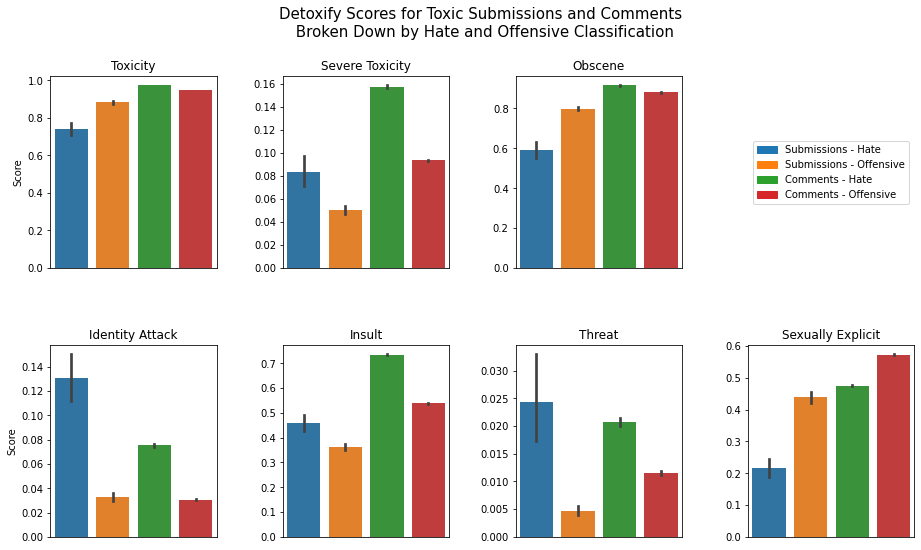

In [ ]:
toxicity_df = pd.concat([submissions_hate.toxicity.to_frame(name='hate_submission'),
                  submissions_offensive.toxicity.to_frame(name='offensive_submission'),
                  comments_hate.toxicity.to_frame(name='hate_comment'),
                  comments_offensive.toxicity.to_frame(name='offensive_comment')],axis=1)
severe_toxicity_df = pd.concat([submissions_hate.severe_toxicity.to_frame(name='hate_submission'),
                  submissions_offensive.severe_toxicity.to_frame(name='offensive_submission'),
                  comments_hate.severe_toxicity.to_frame(name='hate_comment'),
                  comments_offensive.severe_toxicity.to_frame(name='offensive_comment')],axis=1)
obscene_df = pd.concat([submissions_hate.obscene.to_frame(name='hate_submission'),
                  submissions_offensive.obscene.to_frame(name='offensive_submission'),
                  comments_hate.obscene.to_frame(name='hate_comment'),
                  comments_offensive.obscene.to_frame(name='offensive_comment')],axis=1)
identity_attack_df = pd.concat([submissions_hate.identity_attack.to_frame(name='hate_submission'),
                  submissions_offensive.identity_attack.to_frame(name='offensive_submission'),
                  comments_hate.identity_attack.to_frame(name='hate_comment'),
                  comments_offensive.identity_attack.to_frame(name='offensive_comment')],axis=1)
insult_df = pd.concat([submissions_hate.insult.to_frame(name='hate_submission'),
                  submissions_offensive.insult.to_frame(name='offensive_submission'),
                  comments_hate.insult.to_frame(name='hate_comment'),
                  comments_offensive.insult.to_frame(name='offensive_comment')],axis=1)
threat_df = pd.concat([submissions_hate.threat.to_frame(name='hate_submission'),
                  submissions_offensive.threat.to_frame(name='offensive_submission'),
                  comments_hate.threat.to_frame(name='hate_comment'),
                  comments_offensive.threat.to_frame(name='offensive_comment')],axis=1)
sexual_explicit_df = pd.concat([submissions_hate.sexual_explicit.to_frame(name='hate_submission'),
                  submissions_offensive.sexual_explicit.to_frame(name='offensive_submission'),
                  comments_hate.sexual_explicit.to_frame(name='hate_comment'),
                  comments_offensive.sexual_explicit.to_frame(name='offensive_comment')],axis=1)

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
colors = sns.color_palette()

sns.barplot(ax=axes[0, 0], data=toxicity_df).set(xticklabels='',ylabel='Score',title='Toxicity', xticks=())
sns.barplot(ax=axes[0, 1], data=severe_toxicity_df).set(xticklabels='',ylabel='',title='Severe Toxicity', xticks=())
sns.barplot(ax=axes[0, 2], data=obscene_df).set(xticklabels='',ylabel='',title='Obscene', xticks=())
sns.barplot(ax=axes[0, 3]).set(xticklabels='', yticklabels='',frame_on=False, xticks=(), yticks=())
axes[0, 3].legend(handles=[mpatches.Patch(color=colors[0], label='Submissions - Hate'), 
                           mpatches.Patch(color=colors[1], label='Submissions - Offensive'), 
                           mpatches.Patch(color=colors[2], label='Comments - Hate'), 
                           mpatches.Patch(color=colors[3], label='Comments - Offensive')], loc='center')
sns.barplot(ax=axes[1, 0], data=identity_attack_df).set(xticklabels='',ylabel='Score',title='Identity Attack', xticks=())
sns.barplot(ax=axes[1, 1], data=insult_df).set(xticklabels='',ylabel='',title='Insult', xticks=())
sns.barplot(ax=axes[1, 2], data=threat_df).set(xticklabels='',ylabel='',title='Threat', xticks=())
sns.barplot(ax=axes[1, 3], data=sexual_explicit_df).set(xticklabels='',ylabel='',title='Sexually Explicit', xticks=())

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.suptitle('Detoxify Scores for Toxic Submissions and Comments \n Broken Down by Hate and Offensive Classification', y=(1.02),size=15)

    

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b22dad3f-c925-4cd0-bb81-e22d83bd774f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>